In [29]:
import numpy as np
import matplotlib.pyplot as plt
from Environment.Env import Vertex, Graph, Agent_to_graph_assignment, cost_calculator
from Agents.CombUCB_agent import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
nb_iterations = 100
exploration_parameter = 1.5

V = 8 # number of vertices
dropout_egde_rate = 0.3 # rate of edges to delete from the fully connected graph

g = Graph()
for i in range(V):
    g.add(i,i)
    
adj_matrix = np.zeros((V,V))
all_edges = {}
for i in range(1,V):
    for j in range(i,V):
        if np.random.random() > dropout_egde_rate :
            adj_matrix[i,j], adj_matrix[j,i] = 1, 1
            g.addEdge(i,j,1)
            g.addEdge(j,i,1)
            all_edges[(i,j)] = adj_matrix[i,j]
            all_edges[(j,i)] = adj_matrix[j,i]
            
            
            
agents =["sto1",'sto2',"sto3","sto4","sto5",
         "sto6",'sto7',"sto8","sto9","sto10"]

# agents =["sto1",'sto2',"sto3","sto4","sto5"]

assignement = Agent_to_graph_assignment(graph=g,
                                        list_agents_names = agents, adj_matrix=adj_matrix)
agents_dicts = assignement.random_assignement()
agents_dicts

[{'name': 'sto1',
  'infos': {'start': 2,
   'destination': 7,
   'arms': [{'path': [2, 1, 3, 6, 4, 7]},
    {'path': [2, 1, 3, 7]},
    {'path': [2, 1, 4, 6, 3, 7]},
    {'path': [2, 1, 4, 7]},
    {'path': [2, 1, 5, 6, 3, 7]},
    {'path': [2, 1, 5, 6, 4, 7]},
    {'path': [2, 1, 7]},
    {'path': [2, 3, 1, 4, 7]},
    {'path': [2, 3, 1, 5, 6, 4, 7]},
    {'path': [2, 3, 1, 7]},
    {'path': [2, 3, 6, 4, 1, 7]},
    {'path': [2, 3, 6, 4, 7]},
    {'path': [2, 3, 6, 5, 1, 4, 7]},
    {'path': [2, 3, 6, 5, 1, 7]},
    {'path': [2, 3, 7]},
    {'path': [2, 5, 1, 3, 6, 4, 7]},
    {'path': [2, 5, 1, 3, 7]},
    {'path': [2, 5, 1, 4, 6, 3, 7]},
    {'path': [2, 5, 1, 4, 7]},
    {'path': [2, 5, 1, 7]},
    {'path': [2, 5, 6, 3, 1, 4, 7]},
    {'path': [2, 5, 6, 3, 1, 7]},
    {'path': [2, 5, 6, 3, 7]},
    {'path': [2, 5, 6, 4, 1, 3, 7]},
    {'path': [2, 5, 6, 4, 1, 7]},
    {'path': [2, 5, 6, 4, 7]},
    {'path': [2, 7]}]}},
 {'name': 'sto2',
  'infos': {'start': 5,
   'destination': 1,

In [62]:
# initialisation
visits_ini = {}
for key in all_edges.keys():
    visits_ini[key] = 1

beliefs_hat_cost_edges = {} # beliefs of each agent
own_history_of_visits = {} # history of visits of edges proper to each agent
for agent_name in agents :
    beliefs_hat_cost_edges[agent_name] = all_edges
    own_history_of_visits[agent_name] = visits_ini # initializing the number of visits by 1

summary_experiences= []

for t in range(1, nb_iterations):
    list_arms_pulled = []
    for ind_agent, agent_name in enumerate(agents) :
        arms_possible = []
        for arm in agents_dicts[ind_agent]["infos"]['arms']:
            arms_possible.append(arm["path"])
        if "sto" in agent_name :
            agent_class = CombUCB_agent_part1(t=t, 
                                              arms_sto=arms_possible, 
                                              dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                              history_visited_edges=own_history_of_visits[agent_name],
                                              exploration_parameter=exploration_parameter)
            
        arm_to_play = agent_class.step()
        list_arms_pulled.append(arm_to_play)
    
    # Calculating the real costs after by running the agents on the graph each one following his own path 
    # given by his update strategy
    
    cc = cost_calculator(list_arms_pulled=list_arms_pulled, 
                         adj_matrix= adj_matrix)
    summary_round, history_costs_edges = cc.return_costs()
    
    summary_experiences.append(summary_round)
    
    for ind_agent, agent_name in enumerate(agents) :
        if "sto" in agent_name:
            agent_class = CombUCB_agent_part2(arm_played=list_arms_pulled[ind_agent],
                                              cost_edges_observed=history_costs_edges,
                                              old_dict_hat_costs_edges=beliefs_hat_cost_edges[agent_name],
                                              old_history_visited_edges=own_history_of_visits[agent_name])
        beliefs_hat_cost_edges[agent_name], own_history_of_visits[agent_name] = agent_class.update_own_statistics()

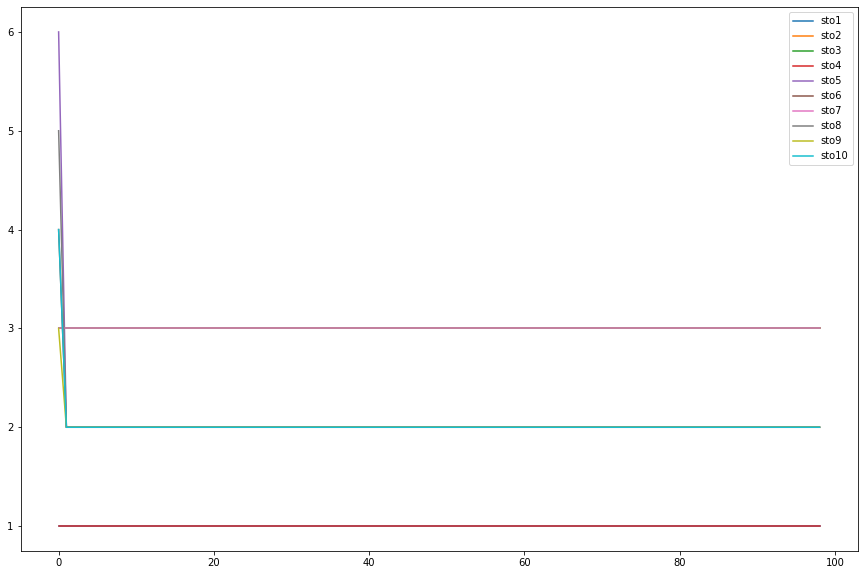

In [63]:
plt.figure(figsize=(15,10))

for ind_agent, agent_name in enumerate(agents):

    plt.plot(range(nb_iterations-1),
             [summary_experiences[t][ind_agent]["cost"] for t in range(nb_iterations-1)],
             label = agent_name)
plt.legend();

**Plotting Evolution of total cost:**

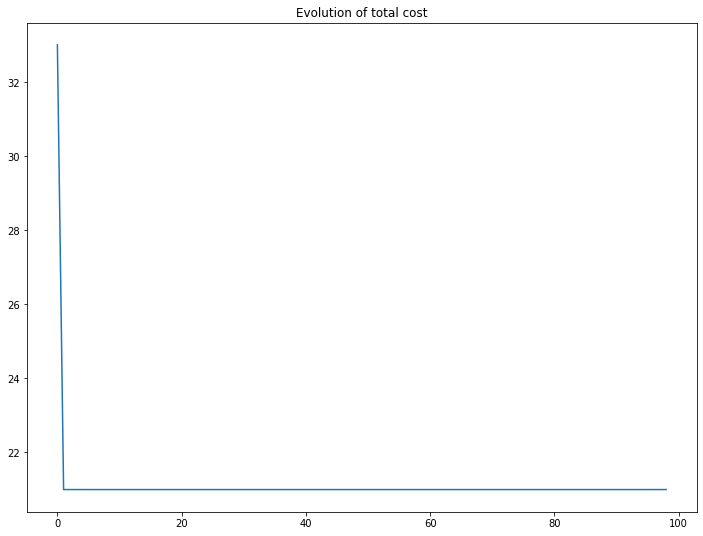

In [64]:
plt.figure(figsize=(12,9))
total_costs = list()
for t in range(nb_iterations-1):
    cost = sum([summary_experiences[t][ind_agent]["cost"] for ind_agent in range(len(agents))])
    total_costs.append(cost)
    
plt.plot(total_costs)
plt.title('Evolution of total cost')
plt.show()

**Computing Optimal Cost :**

In [66]:
assignement.get_optimal_paths(combinatorial=True, time_limit=20)

Time depassed 20 seconds, only 27534 combinations where tested
Total time to compute costs:20.00 s
 => The minimal cost is :  20.0
 => The optimal paths are :  [[2, 7], [5, 1], [1, 5], [3, 2], [4, 1, 3], [4, 1], [1, 2, 5], [4, 7, 2], [6, 5, 1], [4, 6, 3, 1]]
